In [149]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib inline

In [150]:
# параметры будущих 2мерных нормальных распределений
mu0, cov0 = [-2.5, 0.2], [[0.4, 0.0], [0.0, 0.4]]
mu1, cov1 = [1.5, -2.1], [[0.9, 0.0], [0.0, 0.9]]

x_scale, y_scale = np.linspace(-7, 4, 100), np.linspace(-5, 6, 100)

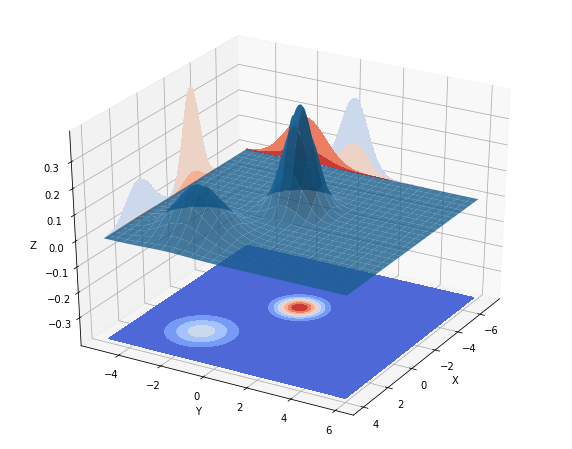

In [151]:
# строим сетку для графика
x, y = np.meshgrid(x_scale, y_scale)
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x
pos[:, :, 1] = y

# 2-мерные нормальные распределения
rv1 = stats.multivariate_normal(mu0, cov0)
rv2 = stats.multivariate_normal(mu1, cov1)

# плотности вероятности
z1_pdf = rv1.pdf(pos)
z2_pdf = rv2.pdf(pos)

# для построения налоложим графики
z_pdf = np.maximum(z1_pdf,z2_pdf)

# строим
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d') # get current axis
ax.view_init(30, 30)

ax.plot_surface(x, y, z_pdf, rstride=4, cstride=4, alpha=0.8)
cset = ax.contourf(x, y, z_pdf, zdir='z', offset=-z_pdf.max(), cmap=cm.coolwarm)
cset = ax.contourf(x, y, z_pdf, zdir='x', offset=x_scale[0], cmap=cm.coolwarm)
cset = ax.contourf(x, y, z_pdf, zdir='y', offset=y_scale[1], cmap=cm.coolwarm)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_zlim(-z_pdf.max(), z_pdf.max())

plt.show()


In [156]:
# Выборка из точек пары 2-мерных норм.распределений
# Возвращает массив (2*n,1) из n пар [x,y] и хвоста из n-штук нулей/единиц (указывающих
# из какого распределения точка на соотв.позиции в перовой n-ке)
def sample2(rv0, rv1, n=32):
    x0 = torch.tensor(rv0.rvs(size=n), dtype=torch.float32)
    x1 = torch.tensor(rv1.rvs(size=n), dtype=torch.float32)
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

sample2(rv1,rv2, 4)

(tensor([[-2.4616, -0.3721],
         [-3.2336, -0.8474],
         [-2.8128,  0.7318],
         [-2.9078,  0.1743],
         [ 1.1784, -3.0724],
         [ 0.7038, -2.6422],
         [ 1.1059, -2.3940],
         [ 3.0536, -3.5242]]), tensor([[0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [1.],
         [1.],
         [1.]]))

In [157]:
# Лиейный преобразователь A*x + B, вход - вектор (2,1), выход - число (по смыслу 
# - вероятность того, что входная точка из 1го или 2го распределения)
layer2 = nn.Linear(2, 1)
print([p.data for p in layer2.parameters()])

# Оптимизатор на стохастическом градиентном спуске
layer_opt2 = optim.SGD(lr=1e-3, params=list(layer2.parameters()))

[tensor([[-0.5977, -0.3902]]), tensor([-0.4883])]


In [158]:
# Обучаемся
log_freq = 500
for i in range(10000):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample2(rv2, rv1, 100000)
            out = torch.sigmoid(layer2(x))
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
        
    layer_opt2.zero_grad()
    x, y = sample2(rv2, rv1, 1024)
    out = torch.sigmoid(layer2(x))
    loss = F.binary_cross_entropy(out, y)
    loss.backward()
    layer_opt2.step()

Ошибка после 0 итераций: 0.427045
Ошибка после 1 итераций: 0.259541
Ошибка после 2 итераций: 0.186917
Ошибка после 3 итераций: 0.149018
Ошибка после 4 итераций: 0.124777
Ошибка после 5 итераций: 0.107936
Ошибка после 6 итераций: 0.095749
Ошибка после 7 итераций: 0.086005
Ошибка после 8 итераций: 0.078773
Ошибка после 9 итераций: 0.072845
Ошибка после 10 итераций: 0.067786
Ошибка после 11 итераций: 0.063374
Ошибка после 12 итераций: 0.059776
Ошибка после 13 итераций: 0.056858
Ошибка после 14 итераций: 0.054138
Ошибка после 15 итераций: 0.051618
Ошибка после 16 итераций: 0.049450
Ошибка после 17 итераций: 0.047213
Ошибка после 18 итераций: 0.045759
Ошибка после 19 итераций: 0.044482


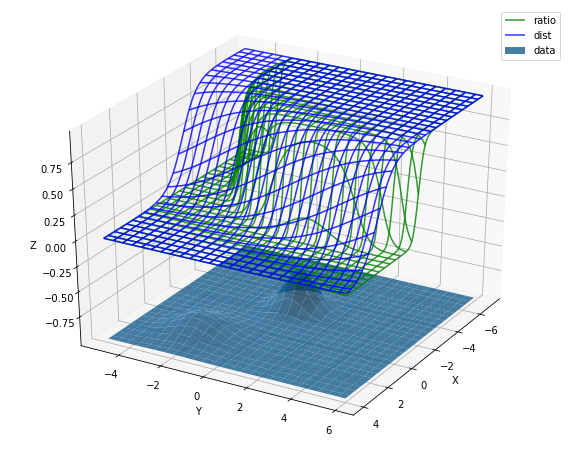

In [159]:
# строим сетку для графика
x, y = np.meshgrid(x_scale, y_scale)
x_len, y_len = len(x), len(y)

# обученное распределение
with torch.no_grad():
    flat_dots = torch.tensor(list(zip(x.flatten(), y.flatten())), dtype=torch.float)
    flat_dist = torch.sigmoid(layer2(flat_dots))
    dist = flat_dist.reshape((x_len,y_len)).numpy()

# нас будут интересовать следующие графики
z_ratio = z1_pdf / (z1_pdf + z2_pdf)
z_dist = dist
z = np.maximum(z1,z2) # исходное "двухголовое" распределение

# строим
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d') # get current axis
ax.view_init(30, 30)

ax.plot_wireframe(x, y, z_ratio, rstride=4, cstride=4, alpha=0.8,color='green',label='ratio')
ax.plot_wireframe(x, y, z_dist, rstride=4, cstride=4, alpha=0.8, color='blue',label='dist')

surf = ax.plot_surface(x, y, z - z_dist.max(), rstride=4, cstride=4, alpha=0.8,label='data')
# 2 строки ниже устраняют ошибку: " 'Poly3DCollection' object has no attribute '_edgecolors2d' "
surf._facecolors2d=surf._facecolors3d 
surf._edgecolors2d=surf._edgecolors3d

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_zlim(-z_ratio.max(), z_ratio.max())
ax.legend()

plt.show()